In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def plot_graph(y_test, y_pred, title):
    plt.plot(y_test, label='y_true')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.title(title)
    plt.ylabel("Gold Week Price")
    plt.show()

In [3]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']

gold = gold[::-1]
gold.head()

,data,today_price
1095,18/06/2000,282.7
1094,25/06/2000,290.1
1093,02/07/2000,283.2
1092,09/07/2000,281.1
1091,16/07/2000,280.1


In [4]:
gold['data']= pd.to_datetime(gold.data, dayfirst=True) #transform data into datetime
gold['last_week_price'] = gold.today_price.shift(1)
filtro = np.where(gold['today_price'] > gold['last_week_price'], 1, 0)
gold['target_subida'] = filtro
gold['next_week_price'] = gold.today_price.shift(-1)
gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean().shift()
gold['m5'] = gold.today_price.rolling(window=5).mean().shift()
gold['m7'] = gold.today_price.rolling(window=7).mean().shift()
gold['m9'] = gold.today_price.rolling(window=9).mean().shift()
gold.dropna(inplace=True)
gold.head()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1087,2000-08-13,276.8,275.1,1,274.1,1.7,274.833333,276.46,278.085714,279.933333
1086,2000-08-20,274.1,276.8,0,277.0,-2.7,275.333333,275.26,276.785714,278.977778
1085,2000-08-27,277.0,274.1,1,273.3,2.9,275.966667,275.12,276.200000,277.522222
1084,2000-09-03,273.3,277.0,0,272.3,-3.7,274.800000,275.26,275.228571,276.422222
1083,2000-09-10,272.3,273.3,0,271.8,-1.0,274.200000,274.70,274.457143,275.444444


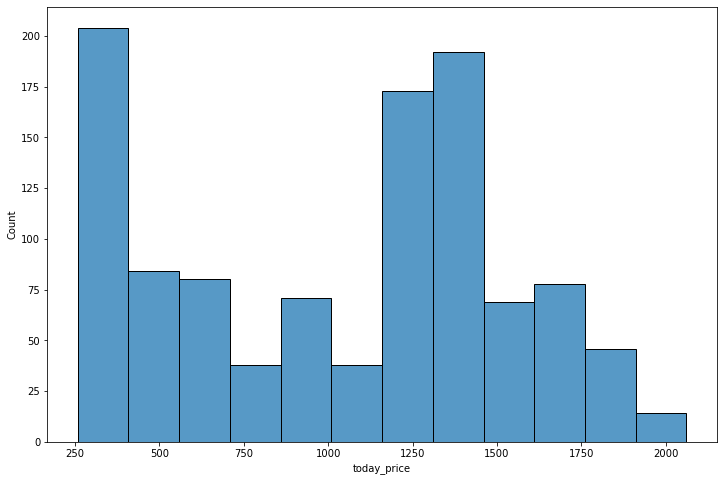

In [5]:
sns.histplot(gold.today_price)

### Normal series

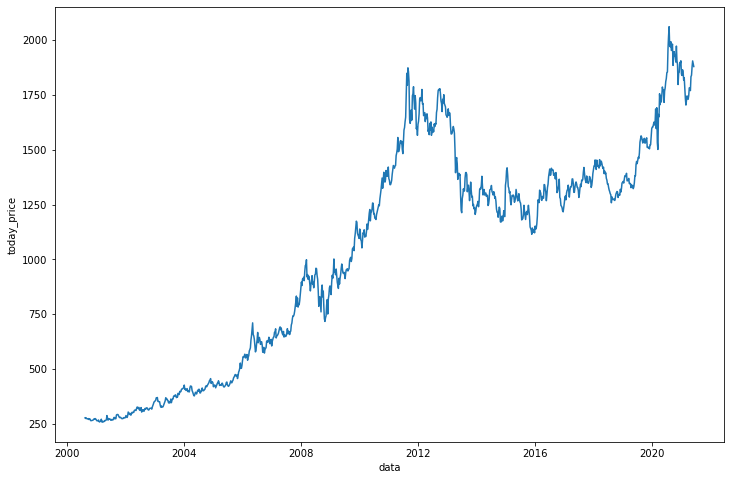

In [6]:
sns.lineplot(x=gold.data,y=gold.today_price)
# sns.lineplot(x=gold.data,y=gold.m7)
# sns.lineplot(x=gold.data,y=gold.m9)

In [7]:
gold.tail()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
5,2021-05-09,1840.0,1833.5,1,1878.9,6.5,1814.433333,1801.08,1783.214286,1773.866667
4,2021-05-16,1878.9,1840.0,1,1905.3,38.9,1850.800000,1820.42,1804.442857,1788.655556
3,2021-05-23,1905.3,1878.9,1,1892.0,26.4,1874.733333,1845.50,1827.085714,1807.411111
2,2021-05-30,1892.0,1905.3,0,1879.6,-13.3,1892.066667,1869.94,1842.771429,1825.377778
1,2021-06-06,1879.6,1892.0,0,1868.0,-12.4,1892.300000,1879.16,1857.014286,1840.133333


# Primeiros Experimentos:

Treinamento utilizando como conjunto de treino os preços atuais (today_price)
e target (next_week_price)


**entra preço -> prediz preço**

In [25]:
X_test_numpy = gold['today_price'].tail(100).to_numpy()
y_test_numpy = gold['next_week_price'].tail(100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test_numpy.shape, y_test_numpy.shape))

Número de linhas: (100,)
Número de colunas: (100,)


In [26]:
X_train_numpy = gold['today_price'].head(-100).to_numpy()
y_train_numpy = gold['next_week_price'].head(-100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train_numpy.shape, y_train_numpy.shape))

Número de linhas: (987,)
Número de colunas: (987,)


In [29]:
X_train_numpy = X_train_numpy.reshape(-1, 1)
X_test_numpy = X_test_numpy.reshape(-1, 1)

### Regressão Linear


RMSE  1923.6899448317824


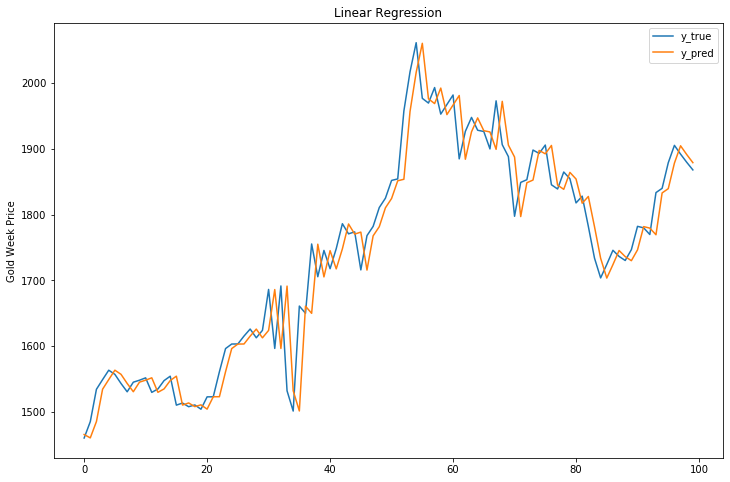

In [22]:
linear = LinearRegression().fit(X_train_numpy, y_train_numpy)
y_pred = linear.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Linear Regression")

### Lasso

RMSE  1923.6899649292338


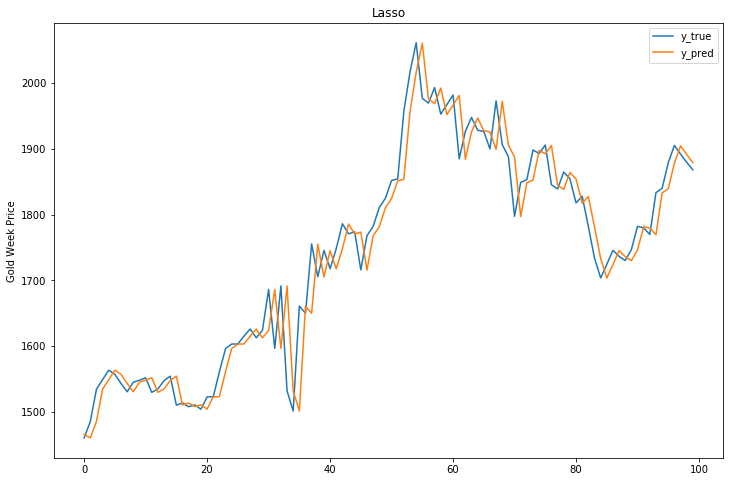

In [14]:
ridge = Ridge().fit(X_train_numpy, y_train_numpy)
y_pred = ridge.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Lasso")

### Random Forest

RMSE  6052.276901135825


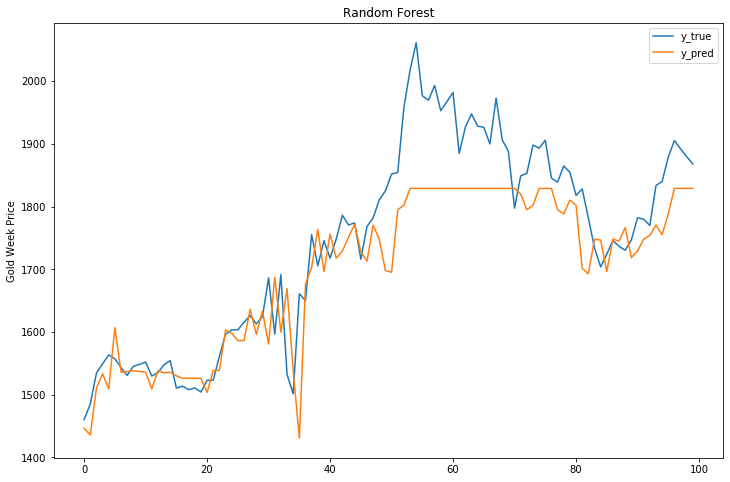

In [15]:
rf = RandomForestRegressor().fit(X_train_numpy, y_train_numpy)
y_pred = rf.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Random Forest")

# Segunda leva de Experimentos:

Agora utilizaremos outros valores como médias móveis e delta de uma semana pra outras

**entra preçohoje, preço semana passada e delta -> prediz se subira ou não**